# Installing necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import pandas_ta as ta
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')


# Stategy PnL

In [22]:
class PnlCalulator:
    def __init__(self,target):
        self.intrade_long = False
        self.intrade_short = False
        self.sl = 0
        self.entry_price = 0
        self.multiplier = target
        self.atr = 0
    
    def Crossover(self):

        df = pd.read_csv('btc_3m_2019-24.csv')
        #df = df.rename(columns ={"signal":"signals","datetime":"timestamp"})
        df['ATR'] = ta.atr(df.high, df.low, df.close, window=14)
        df['target_points'] = None
        df['remarks'] = 'Algo_Exit'

        df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
        df['HA_Open'] = (df['open'] + df['close']) / 2
        df['HA_Open'] = df['HA_Open'].shift(1)  # Shift to use previous period's values
        df['HA_Open'].iloc[0] = df['open'].iloc[0]  # First HA Open is the same as the first original open
        df['HA_High'] = df[['HA_Open', 'HA_Close']].join(df['high']).max(axis=1)
        df['HA_Low'] = df[['HA_Open', 'HA_Close']].join(df['low']).min(axis=1)

        df["Short_MA"] = df["close"].rolling(window=1).mean()
        df["Long_MA"] = df["close"].rolling(window=1259).mean()
        df["sma_long_minus_short"] = df["Long_MA"] - df["Short_MA"]
        df['region'] = df['sma_long_minus_short'].apply(lambda x: 'Short_Region' if x > 0 else 'Long_Region')
        df['mask_1'] = (df['region'] == 'Long_Region') & (df['region'].shift(1) == 'Short_Region')
        df['mask_2'] = (df['region'] == 'Short_Region') & (df['region'].shift(1) == 'Long_Region')
        df['crossover_detection'] = df.apply(lambda row: True if row['mask_1'] else False if row['mask_2'] else row['region'], axis=1)
        df['signal'] = df['crossover_detection'].apply(lambda x: 1 if x == True else 2 if x == False else 0)

        in_trade_long, in_trade_short = False, False
        for i in tqdm(range(len(df))):
            if df['signal'].iloc[i] == 2 and in_trade_long:
                df.at[i-1,'signal'] = -1
                in_trade_long = False
                in_trade_short = True
            elif df['signal'].iloc[i] == 1 and in_trade_short:
                df.at[i-1,'signal'] = -2
                in_trade_long = True
                in_trade_short = False
            elif df['signal'].iloc[i] == 2 and not in_trade_short:
                in_trade_short = True
            elif df['signal'].iloc[i] == 1 and not in_trade_long:
                in_trade_long = True
            
        
        target_points = 0
        entry_price = 0
        sl = 0
        tp = 0
        
        for i in tqdm(range(len(df))):
            if df['signal'].iloc[i] == 1:
                entry_price = df['close'].iloc[i]
                df.at[i, 'target_points'] = self.multiplier * df['ATR'].iloc[i]
                target_points = df['target_points'].iloc[i]
                sl = df['close'].iloc[i] - df['target_points'].iloc[i]
                intrade = True
                
                
            elif df['signal'].iloc[i] == 2:
                entry_price = df['close'].iloc[i]
                df.at[i, 'target_points'] = 11 * df['ATR'].iloc[i]
                target_points = df['target_points'].iloc[i]
                sl = df['close'].iloc[i] + df['target_points'].iloc[i]
                intrade = True
                k = i
                mul = 1
                while k < len(df) and df['signal'].iloc[k] != -2 and intrade:
                    if df['close'].iloc[k] < entry_price-(0.02)*mul*entry_price:
                        new_sl = entry_price - (0.009) *mul* entry_price
                        if new_sl < sl:
                            sl = new_sl
                        mul = mul+1
                    elif df['low'].iloc[k] < sl < df['high'].iloc[k]:
                        df.at[k, 'signal'] = -2
                        df.at[k, 'remarks'] = "SL_Exit"
                        intrade = False
                    k += 1


        d = df[df['signal'] != 0]

        # filtering out repetitive signals
        signal = []
        prev = None
        for value in d["signal"]:
            if value == prev:
                signal.append(0)
            else:
                signal.append(value)
                prev = value

        d["signal"] = signal
        dg = d[d['signal']!=0]

        # creation of PnL file from logs 
        dg['entry_timestamp']= dg['timestamp'] 
        dg['entry_price']= dg['close']
        dg['exit_timestamp']= dg['timestamp'].shift(-1)
        dg['exit_price']= dg['close'].shift(-1)
        dg['remarks']= dg['remarks'].shift(-1)
        pnl= dg[dg['signal']>0][['entry_timestamp', 'entry_price', 'exit_timestamp', 'exit_price', 'signal','target_points','remarks']]

        #calculatig the Overall PnL
        pnl['profit_per_btc'] = np.where(pnl['signal'] == 1, pnl['exit_price'] - pnl['entry_price'], 
                                        np.where(pnl['signal'] == 2, pnl['entry_price'] - pnl['exit_price'], None)) 
        pnl['capital']= 1000
        pnl['#units']= pnl['capital']/pnl['entry_price']
        pnl['profit_per_capital']= pnl['#units']*pnl['profit_per_btc']
        pnl['tnc_cost']= 1
        pnl['profit_after_tnc']= pnl['profit_per_capital']- pnl['tnc_cost']
        pnl['cumulative_profit']= pnl['profit_after_tnc'].cumsum()
        pnl['roe_%']= (pnl['profit_after_tnc']/pnl['capital'])*100
        net_pnl = pnl.reset_index()
            

        return  net_pnl, net_pnl['profit_after_tnc'].sum()

if __name__ == "__main__":
    pnl_calculator = PnlCalulator(target=11)  # Create an instance of PnlCalculator
    obj, net_pnl_amount = pnl_calculator.Crossover()
    
    obj.to_csv('pnl_since_2019.csv', index= False) 
    print("Net PnL:", net_pnl_amount) 
            

100%|██████████| 956734/956734 [00:25<00:00, 37939.80it/s]


Net PnL: 14765.208215050283


# The Plot

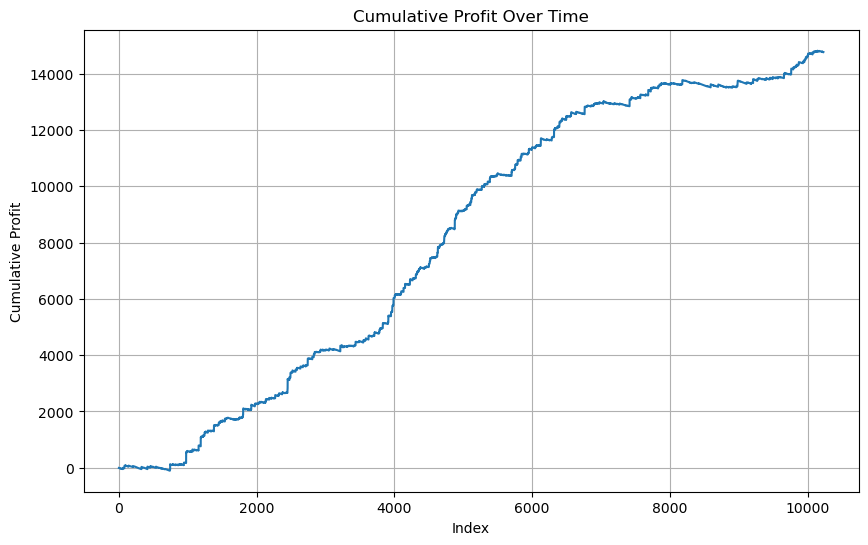

In [23]:
plt.figure(figsize=(10, 6))
plt.plot(obj['cumulative_profit'])
plt.title('Cumulative Profit Over Time')
plt.xlabel('Index')
plt.ylabel('Cumulative Profit')
plt.grid(True)
plt.show()
